In [1]:
from sklearn import preprocessing

import gb # Granger busca, see https://github.com/flaviovdf/granger-busca on how-to install
import numpy as np
import matplotlib.pyplot as plt

# on Ubuntu do: apt install swig
# then: pip install tick (takes a long time)
import tick.hawkes as hk

plt.ion()

See also the multiple examples at: https://x-datainitiative.github.io/tick/

# Hawkes Process Simulation with Tick

In [2]:
# Simulation of a 10-dimensional Hawkes process
beta = 1.
mu = 0.01  # 0.01
d = 10
T = 1e5
H = 10
n_days = 20

mus = mu * np.ones(d)
Alpha = np.zeros((d, d))
Beta = np.zeros((d, d))
for i in range(5):
    for j in range(5):
        if i >= j:
            Alpha[i][j] = 1.
            Beta[i][j] = 100*beta

for i in range(5, 10):
    for j in range(5, 10):
        if i >= j:
            Alpha[i][j] = 1.
            Beta[i][j] = 100*beta
Alpha /= 6
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)]
           for (a_list, b_list) in zip(Alpha, Beta)]
h = hk.SimuHawkes(kernels=kernels, baseline=list(mus), end_time=T)
h.simulate()

----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 2.14e-01 seconds.


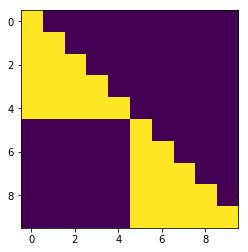

In [3]:
plt.imshow(Alpha)

Let's see if granger-busca is able to recover the model

{0: 3944, 1: 3884, 2: 4979, 3: 5027}
{0: array([4, 1], dtype=uint64), 1: array([9, 6], dtype=uint64), 2: array([3, 2, 5], dtype=uint64), 3: array([8, 7, 0], dtype=uint64)}
[0.00459988 0.00517665 0.00619766 0.007888   0.00917528 0.00452684
 0.00584527 0.00645945 0.00776801 0.0091421 ]


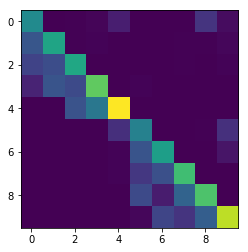

In [4]:
granger_model = gb.GrangerBusca(alpha_prior=1.0/len(h.timestamps), num_iter=2000, metropolis=True, beta_strategy=1)
granger_model.fit(h.timestamps)
print(granger_model.mu_)
np.set_printoptions(precision=2)
plt.imshow(np.array(granger_model.Alpha_.toarray(), dtype='i').T)

# Working with data

### Reading data

In [5]:
# ticks.dat contains a sample of the memetracker dataset,
# the fitting method accepts a list of lists of ordered timestamps
# each index of the list is another list of ticks
timestamps=[]
with open('ticks.dat') as data:
    for l in data:
        timestamps.append([float(x) for x in l.split()[1:]])

In [6]:
names = []
inames = {}
with open('./ticks.dat') as ticks:
    for line in ticks:
        names.append(line.split()[0])
        inames[line.split()[0]] = len(inames)

### Fitting Data

In [7]:
#recommended parameters
granger_model = gb.GrangerBusca(alpha_prior=1.0/len(timestamps), num_iter=300, metropolis=True, beta_strategy=1)
granger_model.fit(timestamps)

{0: 240726, 1: 240725, 2: 240793, 3: 240725}
{0: array([ 0,  9, 41,  2, 28, 40, 37,  5,  8, 15, 23, 44, 52, 68, 56, 67, 61,
       64, 55], dtype=uint64), 1: array([36, 14,  3, 33,  7, 21, 16, 24, 17, 39, 32, 46, 10, 51, 58, 57, 65,
       63], dtype=uint64), 2: array([34,  6, 38, 19, 20, 25, 22, 30, 31,  4,  1], dtype=uint64), 3: array([29, 35, 43, 26, 13, 27, 18, 12, 11, 42, 49, 50, 53, 45, 47, 54, 48,
       59, 66, 60, 62], dtype=uint64)}


### Extracting the normalized Granger Matrix and the Exogeneous rates vector

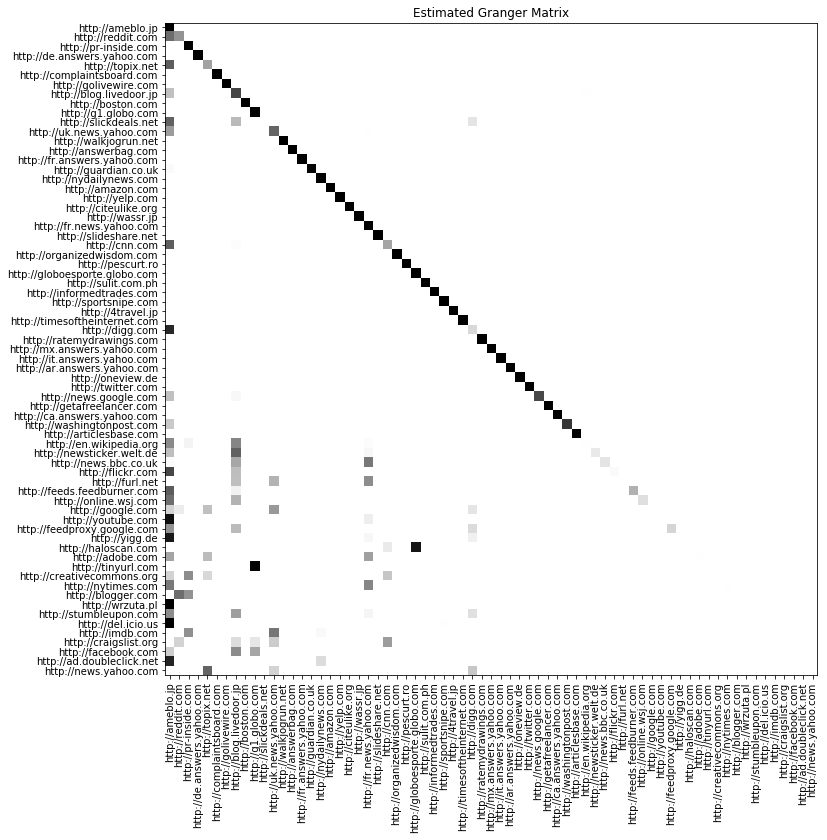

Exogeneous rates vector
[7.25e-03 4.85e-04 9.22e-04 4.54e-04 7.04e-04 4.35e-04 4.87e-04 2.40e-03
 5.24e-04 8.26e-04 0.00e+00 8.77e-04 2.57e-04 4.56e-04 4.89e-04 5.29e-04
 7.04e-04 4.50e-04 4.14e-04 4.44e-04 4.72e-04 1.50e-03 4.35e-04 4.19e-04
 2.60e-04 3.55e-04 6.98e-04 4.59e-04 2.85e-04 5.29e-04 3.91e-04 3.83e-04
 4.36e-04 4.59e-04 5.00e-04 4.91e-04 5.01e-04 3.73e-04 6.25e-04 3.92e-04
 4.59e-04 2.32e-04 3.15e-04 4.44e-04 0.00e+00 5.53e-05 2.88e-05 8.93e-06
 0.00e+00 1.07e-04 7.45e-05 0.00e+00 0.00e+00 4.23e-05 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]


In [8]:
G = preprocessing.normalize(granger_model.Alpha_.toarray(), "l1")
mu = granger_model.mu_
plt.figure(figsize=(12, 12))
plt.imshow(G, cmap=plt.cm.gray_r)
plt.title('Estimated Granger Matrix')
plt.xticks(np.arange(len(names)), names, rotation=90)
plt.yticks(np.arange(len(names)), names)
plt.show()
print('Exogeneous rates vector')
print(mu)

In [9]:
import pandas as pd

top_100 = pd.read_csv('df_09-01.t.csv.top100')
n = len(names)
GT = np.zeros(shape=(n, n), dtype='i')
for row in top_100[['Blog', 'Hyperlink']].values:
    if row[0] in inames and row[1] in inames:
        GT[inames[row[0]], inames[row[1]]] += 1

Compute some accuracy score. Here wer are using kendall correlation

In [10]:
from scipy.stats import kendalltau
ts = []
for i in range(n):
    t = kendalltau(GT.T[i], granger_model.Alpha_.toarray()[i])[0]
    if not np.isnan(t):
        ts.append(t)
np.mean(ts)

0.4166414598950952

In [11]:
realizations = []
realizations.append([np.array(timestamps[i]) for i in range(len(timestamps))])
model = hk.HawkesADM4(decay=1)
model.fit(realizations)

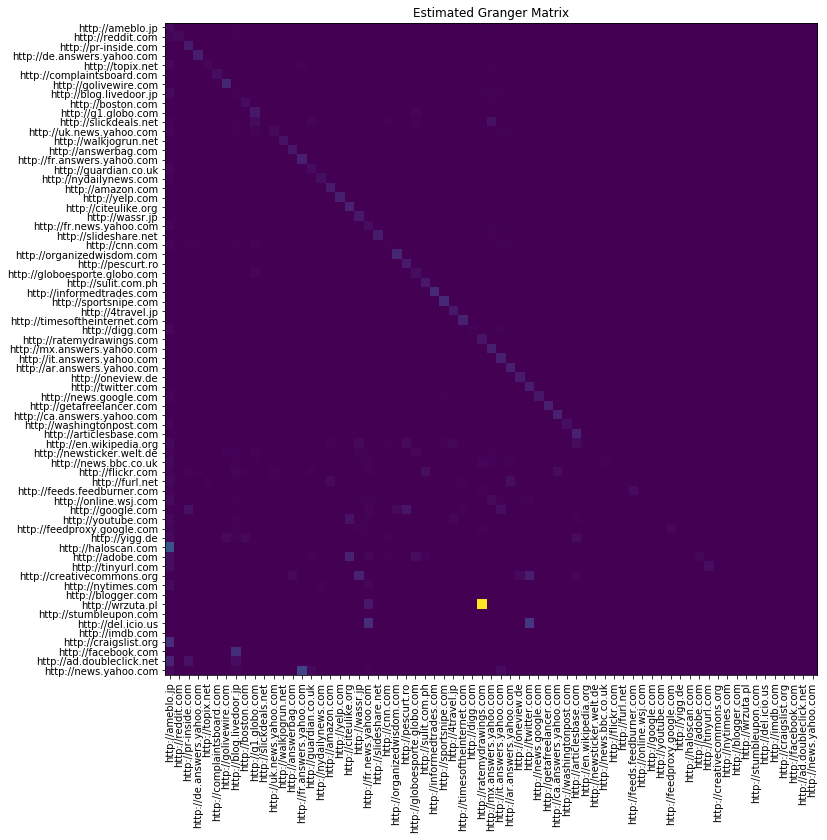

In [12]:
plt.figure(figsize=(12, 12))
plt.imshow(model.get_kernel_norms().T)
plt.title('Estimated Granger Matrix')
plt.xticks(np.arange(len(names)), names, rotation=90);
plt.yticks(np.arange(len(names)), names);

In [13]:
ts = []
for i in range(n):
    t = kendalltau(GT.T[i], model.get_kernel_norms()[i])[0]
    if not np.isnan(t):
        ts.append(t)
np.mean(ts)

0.1646482112473991

### Simulating a Granger-Busca process

In [14]:
from gb import simulate

G_sim = np.ones((5, 5)) / 5
Beta_sim = np.ones((5,5))
mu_sim = 0.01 * np.ones((5))

T_sim=1000
sim = simulate.GrangeBuscaSimulator(mu_sim, G_sim,Beta_sim)
sim_timestamps = sim.simulate(T_sim)

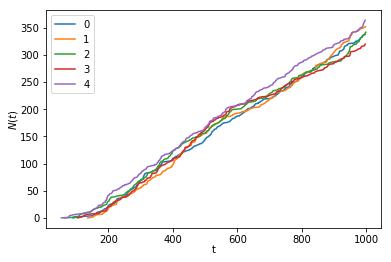

In [15]:
counting = [np.arange(len(sim_timestamps[i])) for i in range(len(sim_timestamps))]
for i in range(len(sim_timestamps)):
    plt.plot(sim_timestamps[i], counting[i], label='%d' % i)
plt.legend()
plt.ylabel('$N(t)$' , labelpad=0)
plt.xlabel('t' , labelpad=0)
plt.show()